
### Setting the Working Enviornment


In [13]:
!pip install pyLDAvis
!pip install wordcloud

In [14]:
#pip install pandas==1.1.2


In [15]:
import pyLDAvis # package to interpret the topics in a topic model
import pyLDAvis.gensim_models # python library for the interactive topic modeling visualization
import pickle # for html export
import pandas as pd # for data processing
import os # for setting working directory
import re # regular expression library
from wordcloud import WordCloud # for generating word clouds
import gensim # open-source library for unsupervised topic modeling, document indexing
from gensim.utils import simple_preprocess
import nltk # python tool kit for NLP
nltk.download('stopwords')
from nltk.corpus import stopwords # for removing stop words
import gensim.corpora as corpora # for mapping words to integers
import warnings
warnings.filterwarnings("ignore")
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZiyiYan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###  Importing Data


In [16]:
import pandas as pd

# File Path
file_path = "Enfuse_Data.csv"

# Read CSV into DataFrame
data = pd.read_csv(file_path)

# Print shape of data
print("Shape of data:", data.shape)

# Print first 10 rows
print(data.head(10))

print(data.columns)


Shape of data: (200, 3)
                            Company  \
0                              zore   
1                        Toornament   
2                            Epulze   
3                         Zogsports   
4                           Inter7s   
5                              CSIT   
6                          Fanatics   
7                         SportLoMo   
8                          Playpass   
9  Corporate Sports\n&Entertainment   

                                    Text_Description  \
0  Our Core Values\nThese are the rules by which ...   
1  We want to provide the best tournament managem...   
2  A World Entertained by Esports and Gaming\nFou...   
3  We believe life is better with real personal c...   
4  Inter7s was established in 2007 but before tha...   
5  We are an international multi-sports organizat...   
6  As a global leader in licensed sports merchand...   
7  Since its inception in 2000, SportLoMo has bee...   
8  We're proud to assist organizations in 

### Inital Pre-Processing Data

In [17]:
import re

# Remove the columns
data = data.drop(columns=['Company', 'Link'])  # Drop the specified columns

In [18]:
# Convert all values in the 'Text_Description' column to strings
data['Text_Description'] = data['Text_Description'].astype(str)

# Remove punctuation/lower casing
data['Text_Description_processed'] = data['Text_Description'].map(lambda x: re.sub('[,\.!?\r]', '', x))

# Remove extra newline characters from the text
data['Text_Description_processed'] = data['Text_Description_processed'].replace(r'\n', ' ', regex=True)

# Replace '\n' with space
data['Text_Description_processed'] = data['Text_Description_processed'].replace(r'\\n', ' ', regex=True)

# Convert the descriptions to lowercase
data['Text_Description_processed'] = data['Text_Description_processed'].str.lower()

# Print out the 10 first rows of data
data['Text_Description_processed'].head(10)

0    our core values these are the rules by which w...
1    we want to provide the best tournament managem...
2    a world entertained by esports and gaming foun...
3    we believe life is better with real personal c...
4    inter7s was established in 2007 but before tha...
5    we are an international multi-sports organizat...
6    as a global leader in licensed sports merchand...
7    since its inception in 2000 sportlomo has been...
8    we're proud to assist organizations in every u...
9    corporate sports & entertainment provides adve...
Name: Text_Description_processed, dtype: object

In [19]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZiyiYan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
print(data.columns)


Index(['Text_Description', 'Text_Description_processed'], dtype='object')


In [21]:
data['Text_Description_processed'].head(12)

0     our core values these are the rules by which w...
1     we want to provide the best tournament managem...
2     a world entertained by esports and gaming foun...
3     we believe life is better with real personal c...
4     inter7s was established in 2007 but before tha...
5     we are an international multi-sports organizat...
6     as a global leader in licensed sports merchand...
7     since its inception in 2000 sportlomo has been...
8     we're proud to assist organizations in every u...
9     corporate sports & entertainment provides adve...
10     welcome to corporate sports a full service ma...
11    corporate sports unlimited has served the atla...
Name: Text_Description_processed, dtype: object

In [22]:
data

,Text_Description,Text_Description_processed
0,Our Core Values\nThese are the rules by which ...,our core values these are the rules by which w...
1,We want to provide the best tournament managem...,we want to provide the best tournament managem...
2,A World Entertained by Esports and Gaming\nFou...,a world entertained by esports and gaming foun...
3,We believe life is better with real personal c...,we believe life is better with real personal c...
4,Inter7s was established in 2007 but before tha...,inter7s was established in 2007 but before tha...
...,...,...
195,We at the Limerick Sports Partnership fully be...,we at the limerick sports partnership fully be...
196,Mountain People is an Irish company started by...,mountain people is an irish company started by...
197,Belief Statement\nAccess to a quality educatio...,belief statement access to a quality education...
198,Offers a diverse range of sports and wellness ...,offers a diverse range of sports and wellness ...


In [23]:
# Create a DataFrame with a new column 'company_id'
companies_infodf = pd.DataFrame(data, columns=['Text_Description_processed'])
companies_infodf['company_id'] = range(len(companies_infodf))

print(companies_infodf)


                            Text_Description_processed  company_id
0    our core values these are the rules by which w...           0
1    we want to provide the best tournament managem...           1
2    a world entertained by esports and gaming foun...           2
3    we believe life is better with real personal c...           3
4    inter7s was established in 2007 but before tha...           4
..                                                 ...         ...
195  we at the limerick sports partnership fully be...         195
196  mountain people is an irish company started by...         196
197  belief statement access to a quality education...         197
198  offers a diverse range of sports and wellness ...         198
199  offers tech-enabled adult social sports and cu...         199

[200 rows x 2 columns]


In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download NLTK resources
nltk.download('punkt')  # Download punkt for word_tokenize
nltk.download('wordnet')  # Download WordNet for lemmatization

# Define preprocessing functions
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize using word_tokenize for more advanced tokenization
    words = word_tokenize(text)
    # Lowercase
    words = [word.lower() for word in words]
    # Remove stopwords, short words, and non-alphabetic words
    words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

# Preprocess text data
processed_texts = [preprocess_text(text) for text in data['Text_Description']]

# Implement Phrase Modeling (Bigrams)
bigram = Phrases(processed_texts, min_count=5, threshold=100)  # Identify common bigrams
bigram_phraser = Phraser(bigram)  # Create a bigram phraser
processed_texts_bigrams = [bigram_phraser[doc] for doc in processed_texts]  # Apply bigram phrasing to texts

# Join the lists of words into strings
processed_texts_strings = [' '.join(words) for words in processed_texts_bigrams]

# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(processed_texts_strings)

# Train an LDA model
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
doc_lda = lda_model.fit_transform(X)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZiyiYan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZiyiYan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
# Get the most likely topic for each document (company)
company_topics = []
for i, doc in enumerate(doc_lda):
    topic_id, _ = max(enumerate(doc), key=lambda x: x[1])
    company_topics.append((data.iloc[i]['Text_Description_processed'], i, topic_id))

# Convert the company topics to DataFrame for easier manipulation
company_topics_df = pd.DataFrame(company_topics, columns=['Text_Description_processed', 'company_id', 'topic_id'])

# Print or save the company topics DataFrame
print(company_topics_df)

# You can also visualize the topics using pyLDAvis or other methods as you did before.


                            Text_Description_processed  company_id  topic_id
0    our core values these are the rules by which w...           0         8
1    we want to provide the best tournament managem...           1         9
2    a world entertained by esports and gaming foun...           2         9
3    we believe life is better with real personal c...           3         8
4    inter7s was established in 2007 but before tha...           4         8
..                                                 ...         ...       ...
195  we at the limerick sports partnership fully be...         195         7
196  mountain people is an irish company started by...         196         8
197  belief statement access to a quality education...         197         0
198  offers a diverse range of sports and wellness ...         198         7
199  offers tech-enabled adult social sports and cu...         199         7

[200 rows x 3 columns]


### Exploratory Data Analysis on the Text Data - WORD CLOUD Generation
To verify our data preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

In [26]:
from wordcloud import WordCloud


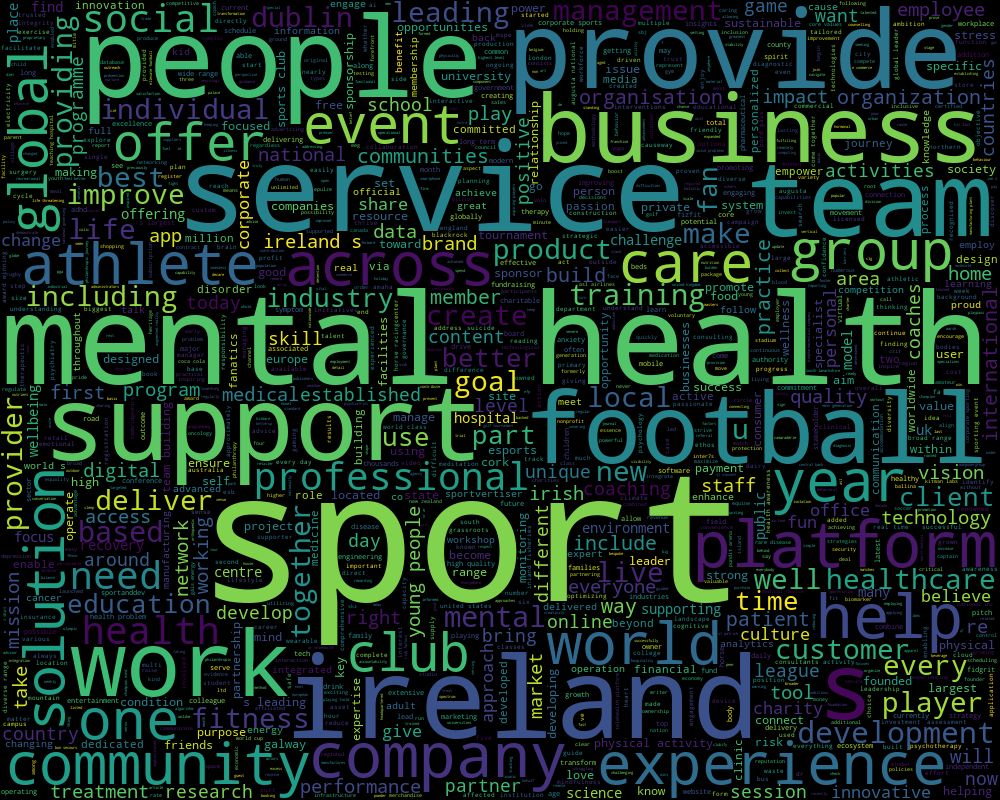

In [27]:
# Join the different processed titles together.
long_string = ','.join(list(company_topics_df['Text_Description_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue',width=1000,height=800)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# Initating the LDA Analysis
Transforming the textual data in a format that will serve as an input for training LDA model.

In [28]:
import nltk
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZiyiYan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
import gensim


In [30]:
try:
    import gensim
    print("gensim is installed")

    if hasattr(gensim.utils, 'simple_preprocess'):
        print("gensim.utils.simple_preprocess is available")
    else:
        print("gensim.utils.simple_preprocess is not available")
except ImportError:
    print("gensim is not installed")


gensim is installed
gensim.utils.simple_preprocess is available


In [31]:
import gensim
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'our', 're', 'we', 'used', 'to', 'in', 'before', 'is', 'within', 's', 'know', 'will', 'go', 'non', 'new', 'u', 't', 'aim', 'inc',
                    'ireland', 'also','us', 'better', 'years', 'across', 'dublin', 'around', 'esports', 'one'
                    , 'asl', 'world', 'long', 'online', 'ie', 'high', 'galway', 'horse', 'irish', 'augusta','people',
                   'staff', 'cie', 'well', 'cx', 'everyone', 'bon', 'waste', 'today', 'every', 'plants', 'many', 'cwo'
                   , 'big', 'day', 'st', 'beds', 'hospital', 'cambridgeshire', 'cancer' ])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

constructed_data = company_topics_df.Text_Description_processed.values.tolist()
data_words = list(sent_to_words(constructed_data))
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])


['core', 'values', 'rules', 'play', 'culture', 'decisions', 'experiences', 'deliver', 'shaped', 'six', 'core', 'values', 'vsrij', 'fun', 'facilitate', 'fun', 'fun', 'making', 'happen', 'dhk', 'team', 'player', 'spirit', 'camaraderie', 'share', 'ideas', 'efforts', 'resources', 'accomplish', 'goals']


In [32]:
from gensim import corpora
from nltk.corpus import stopwords

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Printing the corpus in a numeric form which implies the frequency of the word
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [34]:
#Showing the code
id2word

###  LDA model tranining
Transforming the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [35]:
import numpy as np
import gensim
from gensim.models import CoherenceModel

# Set random seed for reproducibility
np.random.seed(1)

# Define parameters
start_topics = 5
end_topics = 25
step_size = 1
passes = 10  # Increase the number of passes
iterations = 100  # Increase the number of iterations

# Initialize variables to store results
coherence_scores = []

# Iterate through different numbers of topics
for num_topics in range(start_topics, end_topics + 1, step_size):
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            passes=passes,
                                            iterations=iterations)  # Adjust passes and iterations

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

# Find the optimal number of topics
optimal_num_topics = start_topics + np.argmax(coherence_scores) * step_size
print("Optimal number of topics:", optimal_num_topics)

# Build the final LDA model with the optimal number of topics
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=optimal_num_topics,
                                             passes=passes,
                                             iterations=iterations)  # Adjust passes and iterations

# Print the Keyword in the optimal number of topics
pprint(lda_model_final.print_topics())
doc_lda_final = lda_model_final[corpus]

Optimal number of topics: 23
[(20,
  '0.055*"health" + 0.049*"mental" + 0.016*"support" + 0.013*"risk" + '
  '0.010*"help" + 0.008*"healthcare" + 0.007*"care" + 0.006*"together" + '
  '0.006*"clients" + 0.006*"amaha"'),
 (15,
  '0.014*"platform" + 0.011*"health" + 0.008*"monitoring" + 0.008*"help" + '
  '0.006*"business" + 0.006*"best" + 0.006*"clients" + 0.006*"cork" + '
  '0.006*"products" + 0.006*"corporate"'),
 (1,
  '0.019*"team" + 0.014*"support" + 0.013*"events" + 0.011*"building" + '
  '0.011*"sports" + 0.011*"international" + 0.010*"services" + '
  '0.009*"fisheries" + 0.009*"service" + 0.009*"based"'),
 (13,
  '0.017*"business" + 0.011*"industry" + 0.009*"platform" + 0.008*"mspe" + '
  '0.008*"sports" + 0.007*"mountain" + 0.006*"company" + 0.006*"sport" + '
  '0.006*"experience" + 0.005*"circle"'),
 (5,
  '0.019*"platform" + 0.013*"club" + 0.013*"telehealth" + 0.010*"rugby" + '
  '0.010*"healthcare" + 0.010*"vr" + 0.010*"xrhealth" + 0.010*"ar" + '
  '0.006*"captain" + 0.006*"

In [36]:
import numpy as np
from pprint import pprint
# number of topics
num_topics = 23

np.random.seed(1)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(12,
  '0.023*"sports" + 0.007*"training" + 0.006*"community" + 0.006*"social" + '
  '0.006*"education" + 0.005*"fun" + 0.005*"players" + 0.005*"platform" + '
  '0.005*"clubs" + 0.005*"club"'),
 (2,
  '0.013*"sports" + 0.009*"clubs" + 0.008*"sportvertiser" + 0.007*"platform" + '
  '0.007*"solutions" + 0.007*"information" + 0.005*"management" + '
  '0.005*"sponsorship" + 0.005*"insurance" + 0.005*"sport"'),
 (6,
  '0.012*"sport" + 0.011*"health" + 0.011*"platform" + 0.010*"mental" + '
  '0.009*"development" + 0.006*"company" + 0.006*"sports" + 0.005*"healthcare" '
  '+ 0.005*"racing" + 0.005*"industry"'),
 (0,
  '0.009*"national" + 0.009*"support" + 0.008*"provide" + 0.007*"sports" + '
  '0.006*"services" + 0.006*"events" + 0.006*"community" + 0.006*"sport" + '
  '0.006*"service" + 0.005*"health"'),
 (22,
  '0.013*"mental" + 0.008*"platform" + 0.008*"airlines" + 0.007*"health" + '
  '0.007*"company" + 0.006*"medical" + 0.006*"football" + 0.006*"fitness" + '
  '0.006*"based" + 0.005*"da

In [37]:
company_topics_df

,Text_Description_processed,company_id,topic_id
0,our core values these are the rules by which w...,0,8
1,we want to provide the best tournament managem...,1,9
2,a world entertained by esports and gaming foun...,2,9
3,we believe life is better with real personal c...,3,8
4,inter7s was established in 2007 but before tha...,4,8
...,...,...,...
195,we at the limerick sports partnership fully be...,195,7
196,mountain people is an irish company started by...,196,8
197,belief statement access to a quality education...,197,0
198,offers a diverse range of sports and wellness ...,198,7


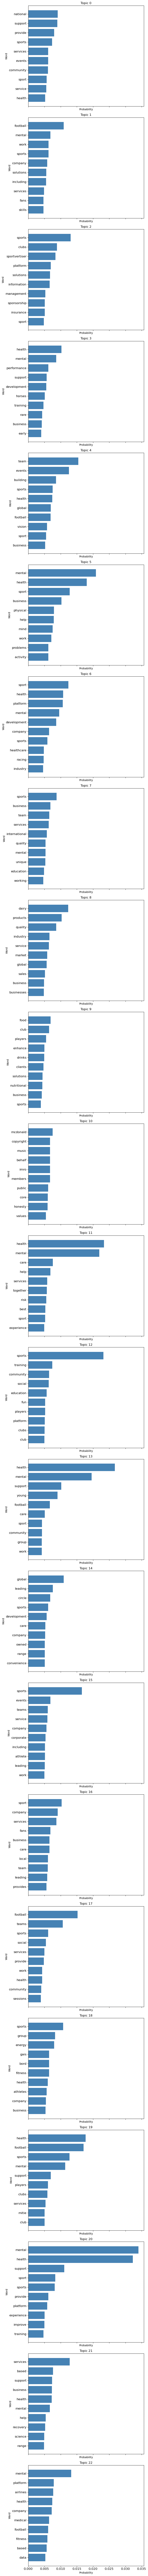

In [38]:
import matplotlib.pyplot as plt

def visualize_topics(lda_model, num_topics, n_words):
    fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(8, 6*num_topics), sharex=True)
    axes = axes.flatten()
    for topic_id, topic_words in lda_model.show_topics(num_topics=num_topics, num_words=n_words, formatted=False):
        topic_words = dict(topic_words)
        ax = axes[topic_id]
        ax.barh(list(topic_words.keys()), topic_words.values(), color='steelblue')
        ax.set_title(f'Topic {topic_id}')
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylabel('Word')
        ax.set_xlabel('Probability')
    plt.tight_layout()
    plt.show()

# Visualize the topics in a bar chart format
visualize_topics(lda_model, num_topics=23, n_words=10)


### Analysing the LDA Model



In [39]:
!pip install pyldavis


In [40]:
from IPython.display import display, HTML

In [41]:
import pyLDAvis
import os

pyLDAvis.enable_notebook()


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join("",'ldavis_prepared_'+str(num_topics))


if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared,'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.093638 -0.075360       1        1  10.923324
6     -0.053693 -0.011932       2        1   8.271394
12    -0.019307  0.106946       3        1   6.351133
15    -0.016063  0.078843       4        1   5.984437
7     -0.023758  0.015454       5        1   5.837756
4     -0.033162  0.069554       6        1   5.519175
11    -0.069850 -0.063267       7        1   5.131063
20    -0.094023 -0.057915       8        1   5.046112
18     0.000473  0.023850       9        1   4.784644
22    -0.004611 -0.057710      10        1   4.718333
17     0.021768  0.001270      11        1   4.649744
19    -0.006210  0.031227      12        1   4.415823
0     -0.032051  0.032704      13        1   4.378402
16     0.014902  0.050491      14        1   4.245865
5     -0.030218 -0.072554      15        1   3.528303
14     0.021745  0.019058      16        1   3.170389
21     0.019729 -0.031883      17        1   3.140964
1      0.010792  0.023968      18        1   3.131994
2      0.006573  0.043903      19        1   2.286654
3      0.077738 -0.069319      20        1   2.003824
10     0.101085 -0.021545      21        1   1.136895
8      0.137805 -0.054737      22        1   0.938098
9      0.063975  0.018956      23        1   0.405675, topic_info=             Term        Freq       Total Category  logprob  loglift
264        health  134.000000  134.000000  Default  30.0000  30.0000
276        mental  120.000000  120.000000  Default  29.0000  29.0000
255      football   55.000000   55.000000  Default  28.0000  28.0000
206        sports   95.000000   95.000000  Default  27.0000  27.0000
481      products   20.000000   20.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1902  performance    0.169930   17.770578  Topic23  -5.6962   0.8575
206        sports    0.196910   95.290108  Topic23  -5.5488  -0.6746
6     communities    0.167736   19.364301  Topic23  -5.7092   0.7586
264        health    0.177325  134.944903  Topic23  -5.6536  -1.1273
125       leading    0.151329   32.516724  Topic23  -5.8121   0.1373

[1494 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2288     18  0.759954       aberdeen
2847      3  0.616185        academy
849       3  0.183294     accessible
849      13  0.366588     accessible
2074      2  0.263826  accommodation
...     ...       ...            ...
969      11  0.050280          young
969      13  0.050280          young
969      14  0.050280          young
969      15  0.050280          young
541       6  0.498631        zealand

[3130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 7, 13, 16, 8, 5, 12, 21, 19, 23, 18, 20, 1, 17, 6, 15, 22, 2, 3, 4, 11, 9, 10])

In [44]:
# Explore the topics and keywords
for topic_id, topic_keywords in enumerate(lda_model.print_topics()):
    print(f"Topic {topic_id}:")
    print(topic_keywords)
    print()




Topic 0:
(18, '0.011*"sports" + 0.008*"group" + 0.008*"energy" + 0.006*"gais" + 0.006*"bord" + 0.006*"fitness" + 0.006*"health" + 0.006*"athletes" + 0.005*"company" + 0.005*"business"')

Topic 1:
(6, '0.012*"sport" + 0.011*"health" + 0.011*"platform" + 0.010*"mental" + 0.009*"development" + 0.006*"company" + 0.006*"sports" + 0.005*"healthcare" + 0.005*"racing" + 0.005*"industry"')

Topic 2:
(2, '0.013*"sports" + 0.009*"clubs" + 0.008*"sportvertiser" + 0.007*"platform" + 0.007*"solutions" + 0.007*"information" + 0.005*"management" + 0.005*"sponsorship" + 0.005*"insurance" + 0.005*"sport"')

Topic 3:
(20, '0.034*"mental" + 0.032*"health" + 0.011*"support" + 0.008*"sport" + 0.008*"sports" + 0.006*"provide" + 0.006*"platform" + 0.005*"experience" + 0.005*"improve" + 0.005*"training"')

Topic 4:
(4, '0.015*"team" + 0.013*"events" + 0.009*"building" + 0.008*"sports" + 0.007*"health" + 0.007*"global" + 0.007*"football" + 0.006*"vision" + 0.005*"sport" + 0.005*"business"')

Topic 5:
(13, '0.02

In [45]:
np.random.seed(12345)

# Initialize a dictionary to store related companies by topic
related_companies_by_topic = {}

# Iterate through each document (company)
for company_id, doc_topics in enumerate(doc_lda):
    # Find the dominant topic for the document
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
    # Retrieve associated company ID(s) for the document
    company_ids = [company_id]  # Replace with your actual method to get company IDs
    # Update related companies by topic
    if dominant_topic not in related_companies_by_topic:
        related_companies_by_topic[dominant_topic] = set()
    related_companies_by_topic[dominant_topic].update(company_ids)

# Print or analyze the related companies for each topic
for topic, companies in related_companies_by_topic.items():
    print(f"Related Companies for Topic {topic}: {companies}")


Related Companies for Topic 13: {0, 64, 194, 106, 120, 175, 145, 53, 22, 119, 24, 155, 28, 62, 31}
Related Companies for Topic 17: {1, 4, 132, 43, 82, 55, 23, 26, 27}
Related Companies for Topic 12: {2, 195, 38, 73, 15, 112, 81, 148, 180, 123, 92}
Related Companies for Topic 18: {96, 192, 3, 131, 5, 7, 103, 50, 116, 54, 57}
Related Companies for Topic 14: {97, 67, 133, 6, 139, 44, 77, 90, 61}
Related Companies for Topic 7: {32, 134, 8, 40, 137, 45, 110, 156, 115, 186, 124, 189, 95}
Related Companies for Topic 15: {162, 185, 9, 12, 143, 121, 58, 190}
Related Companies for Topic 16: {66, 99, 164, 10, 170, 48, 49, 182, 184, 122, 59, 126}
Related Companies for Topic 0: {128, 35, 36, 42, 11, 13, 51, 85, 118, 158, 94}
Related Companies for Topic 22: {130, 166, 168, 169, 78, 14, 47, 174, 88, 153, 29}
Related Companies for Topic 4: {191, 199, 76, 16, 179, 181, 56, 60, 152, 127}
Related Companies for Topic 10: {17, 129, 86, 111}
Related Companies for Topic 6: {65, 161, 163, 108, 141, 18, 52, 21

In [46]:
# Initialize a dictionary to store relevance scores for each company
company_relevance_scores = {}

# Iterate through each document (company)
for company_id, doc_topics in enumerate(doc_lda):
    # Iterate through each topic in the document
    for topic_id, topic_prob in doc_topics:
        # Update relevance score for the company and topic
        if company_id not in company_relevance_scores:
            company_relevance_scores[company_id] = {}
        if topic_id not in company_relevance_scores[company_id]:
            company_relevance_scores[company_id][topic_id] = 0
        company_relevance_scores[company_id][topic_id] += topic_prob

# Calculate total relevance score for each company across all topics
company_total_relevance_scores = {company_id: sum(topic_scores.values()) for company_id, topic_scores in company_relevance_scores.items()}

# Find the company with the highest total relevance score
most_optimal_company = max(company_total_relevance_scores, key=company_total_relevance_scores.get)

# Print or analyze the most optimal company
print(f"The most optimal company is: {most_optimal_company} with a total relevance score of {company_total_relevance_scores[most_optimal_company]}")


The most optimal company is: 22 with a total relevance score of 0.996784120798111


In [47]:
# Get the dominant topic ID and its probability for the most optimal company
dominant_topic_id, dominant_topic_prob = max(company_relevance_scores[most_optimal_company].items(), key=lambda x: x[1])

# Initialize a variable to store the related companies for the dominant topic of the most optimal company
related_companies_for_dominant_topic = set()

# Iterate through each related topic and its associated companies
for topic_id, related_companies in related_companies_by_topic.items():
    # If the dominant topic of the most optimal company matches the current topic ID
    if dominant_topic_id == topic_id:
        # Update the set of related companies for the dominant topic
        related_companies_for_dominant_topic.update(related_companies)

# Check if the most optimal company is in the set of related companies for its dominant topic
if most_optimal_company in related_companies_for_dominant_topic:
    print(f"The most optimal company (Company ID: {most_optimal_company}) is related to its dominant topic (Topic {dominant_topic_id}) with a probability of {dominant_topic_prob}.")
else:
    print(f"The most optimal company (Company ID: {most_optimal_company}) is not in the related companies for its dominant topic (Topic {dominant_topic_id}).")



The most optimal company (Company ID: 22) is related to its dominant topic (Topic 13) with a probability of 0.6029784083366394.


In [48]:
# Get the dominant topic ID and its probability for the most optimal company
dominant_topic_id, dominant_topic_prob = max(company_relevance_scores[most_optimal_company].items(), key=lambda x: x[1])

# Print the dominant topic ID and its probability for the most optimal company
print(f"The most optimal company (Company ID: {most_optimal_company}) is related to its dominant topic (Topic {dominant_topic_id}) with a probability of {dominant_topic_prob}.")

# Get the keywords for the dominant topic from the LDA model
dominant_topic_keywords = lda_model.show_topic(dominant_topic_id)

# Print the keywords for the dominant topic
print(f"Keywords for Topic {dominant_topic_id}:")
for word, prob in dominant_topic_keywords:
    print(f"- {word}: {prob}")


The most optimal company (Company ID: 22) is related to its dominant topic (Topic 13) with a probability of 0.6029784083366394.
Keywords for Topic 13:
- health: 0.026734957471489906
- mental: 0.019563358277082443
- support: 0.010170238092541695
- young: 0.009013963863253593
- football: 0.006683925166726112
- care: 0.005065340083092451
- sport: 0.0042363498359918594
- community: 0.0042123026214540005
- group: 0.004196303430944681
- work: 0.004157605115324259


Using Company ID 22's keywords to get similar companies

In [49]:
keywords = ['health', 'mental', 'support', 'young', 'football',
            'care', 'mental', 'sport', 'community', 'group', 'work']


Keyword Counts

In [50]:
#Initialize CountVectorizer with custom vocabulary (keywords)
vectorizer = CountVectorizer(vocabulary=keywords)

In [51]:
#Get the counts of each keyword across all descriptions
keyword_counts = X.sum(axis=0)

In [52]:
#Convert the counts to a dictionary for easier access
keyword_counts_dict = {keyword: count for keyword, count in zip(keywords, keyword_counts.A1)}

In [53]:
#Print the counts of each keyword
print("Keyword Counts:")
for keyword, count in keyword_counts_dict.items():
    print(f"{keyword}: {count} occurrences")

Keyword Counts:
health: 8 occurrences
mental: 3 occurrences
support: 20 occurrences
young: 6 occurrences
football: 4 occurrences
care: 2 occurrences
sport: 2 occurrences
community: 9 occurrences
group: 3 occurrences
work: 4 occurrences


In [54]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZiyiYan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
keyword_occurrence = {}
for index, row in company_topics_df.iterrows():
  description = row['Text_Description_processed']
  for keyword in keywords:
    if keyword in description:
      keyword_occurrence.setdefault(row['company_id'], []).append(keyword)

In [56]:
#Calculate keyword occurrences per company
keyword_counts = {company: len(keywords) for company, keywords in keyword_occurrence.items()}

In [57]:
#Rank companies based on keyword occurrences
ranked_companies = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)

In [58]:
#Recommend top companies with high keyword occurrences
top_companies = ranked_companies[:10] #10 for starters

In [59]:
# Print the top recommended companies
print("\nTop Recommended Companies:")
for company, count in top_companies:
    print(f"Company ID {company}: {count} keyword occurrences")



Top Recommended Companies:
Company ID 22: 9 keyword occurrences
Company ID 37: 9 keyword occurrences
Company ID 20: 8 keyword occurrences
Company ID 28: 8 keyword occurrences
Company ID 39: 8 keyword occurrences
Company ID 21: 7 keyword occurrences
Company ID 23: 7 keyword occurrences
Company ID 40: 7 keyword occurrences
Company ID 141: 7 keyword occurrences
Company ID 175: 7 keyword occurrences


In [60]:
# Print the top recommended companies with their topics
print("\nTop Recommended Companies:")
for company, count in top_companies:
    # Retrieve the topics associated with the current company
    company_topics = doc_lda[company]
    # Print the company ID and keyword occurrences
    print(f"Company ID {company}: {count} keyword occurrences")
    # Print the topics and their probabilities for the company
    print("Topics and their probabilities:")
    for topic_id, topic_prob in company_topics:
        print(f"Topic {topic_id}: Probability {topic_prob}")




Top Recommended Companies:
Company ID 22: 9 keyword occurrences
Topics and their probabilities:
Topic 13: Probability 0.6029801368713379
Topic 20: Probability 0.3938039541244507
Company ID 37: 9 keyword occurrences
Topics and their probabilities:
Topic 19: Probability 0.9931172728538513
Company ID 20: 8 keyword occurrences
Topics and their probabilities:
Topic 11: Probability 0.9874128699302673
Company ID 28: 8 keyword occurrences
Topics and their probabilities:
Topic 13: Probability 0.9902359247207642
Company ID 39: 8 keyword occurrences
Topics and their probabilities:
Topic 5: Probability 0.9951683282852173
Company ID 21: 7 keyword occurrences
Topics and their probabilities:
Topic 6: Probability 0.5163097381591797
Topic 13: Probability 0.13258950412273407
Topic 15: Probability 0.24787189066410065
Topic 18: Probability 0.09903046488761902
Company ID 23: 7 keyword occurrences
Topics and their probabilities:
Topic 13: Probability 0.07722952216863632
Topic 17: Probability 0.914615571498

In [61]:
print("\nTop Recommended Companies with High Probability Topics:")
for company, count in top_companies:
    # Retrieve the topics associated with the current company
    company_topics = doc_lda[company]
    # Filter topics with probability > 0.9
    high_probability_topics = [(topic_id, topic_prob) for topic_id, topic_prob in company_topics if topic_prob > 0.9]
    # Check if there are topics with probability > 0.9
    if high_probability_topics:
        # Print the company ID and keyword occurrences
        print(f"Company ID {company}: {count} keyword occurrences")
        # Print topics with probability > 0.9
        print("Topics with probability > 0.9:", high_probability_topics)
        print()  # Add an empty line for readability



Top Recommended Companies with High Probability Topics:
Company ID 37: 9 keyword occurrences
Topics with probability > 0.9: [(19, 0.9931173)]

Company ID 20: 8 keyword occurrences
Topics with probability > 0.9: [(11, 0.98741287)]

Company ID 28: 8 keyword occurrences
Topics with probability > 0.9: [(13, 0.9902359)]

Company ID 39: 8 keyword occurrences
Topics with probability > 0.9: [(5, 0.9951683)]

Company ID 23: 7 keyword occurrences
Topics with probability > 0.9: [(17, 0.9145891)]

Company ID 141: 7 keyword occurrences
Topics with probability > 0.9: [(6, 0.93643355)]

Company ID 175: 7 keyword occurrences
Topics with probability > 0.9: [(13, 0.9925836)]



Visualization - Keyword Occurrences for top companies

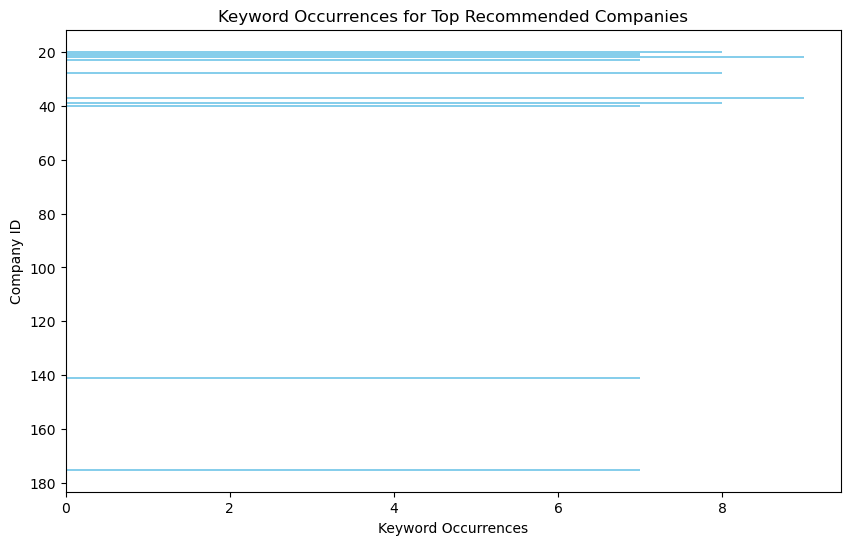

In [62]:
# Visualize keyword occurrences for the top recommended companies
top_company_ids, top_company_counts = zip(*top_companies)
plt.figure(figsize=(10, 6))
plt.barh(top_company_ids, top_company_counts, color='skyblue')
plt.xlabel('Keyword Occurrences')
plt.ylabel('Company ID')
plt.title('Keyword Occurrences for Top Recommended Companies')
plt.gca().invert_yaxis()  # Invert y-axis to display top companies at the top
plt.show()


## Some of the Steps we could to to improve the code above:

These are some recommendations from the material I have read:
1. Improving the Input Matrix which goes into the Model by using Natural Processing Functions like Lemmatization, Stemming and Pharse Modeling (using bi-gram or tri-gram features)
2. Iterating on different Number of topics to view the quality of topics being created. And the quality of topics will also depend on the stop words we use. So we will need to be exhaustive with the stop words to have good topics.
3. Using Model Perplexity & Coherence Score to decide on the optimal no. of Topics
4. Our normal DMML Hyperparamter Tuning of the Model Parameters